# Synthetic models

We generate data from synthetic models and report the number and accuracy of inferred minimal models depending on the number of constraints.

In [1]:
import bonesis
import networkx as nx
from bonesis.snippets import *
import pandas as pd
from tqdm import tqdm
import random

In [2]:
bonesis.settings["quiet"] = True

## Model generation

In [3]:
nb_fp_min = 2
bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete("abcde"))
bo.custom(":- node(I), #count { J: clause(I,_,J,_) } < 2.")
cfgs = []
for _ in range(nb_fp_min):
    cfgs.append(bo.cfg())
    bo.fixed(cfgs[-1])
all_different(cfgs)
             
bns = list(bo.diverse_boolean_networks(limit=4))
pd.DataFrame(bns)

Found 4 solutions in 0.2s (first in 0.1s; rate 0.1s)

,a,b,c,d,e
0,c&!e,a&!c,!b&!e,e|(c&d),e|(c&d)
1,d&e,c&!d,d&e,d|!b,e|c
2,!e|a,d&!e,!b&e,e|!d|b,!e|c
3,e|!a,b&!d,d&e,d&e,e|d


## Helper functions

In [4]:
def extract_edges(ig):
    return list(sorted([(a,b,d["sign"]) for (a,b,d) in ig.edges(data=True)]))

In [5]:
def repr_range(s):
    mi = min(s)
    ma = max(s)
    if mi == ma:
        return mi
    else:
        return f"{mi}-{ma}"

def diff_dyn(bn):
    dyn2 = bn.dynamics("asynchronous")
    return len(set(dyn2.edges()) - set(dyn.edges())), len(set(dyn.edges())-set(dyn2.edges()))


def make_stats(results):
    stats =  {nb: {
        "min models": len(r),
        "size": repr_range(set((len(ig) for ig, _ in r))),
        f"overlap (/{len(truth_ig)})": repr_range(set((len(set(ig).intersection(truth_ig))) for ig,_ in r)),
    } for nb, r in results.items()}
    for nb, r in results.items():
        devs = set()
        misses = set()
        for _, bn in r:
            dev,miss = diff_dyn(bn)
            devs.add(dev)
            misses.add(miss)
        stats[nb]["spurious trans"] = repr_range(devs)
        stats[nb]["missing trans"] = repr_range(misses)
    return pd.DataFrame(stats).T



In [6]:
from IPython.display import SVG, display
import matplotlib.pyplot as plt

In [7]:
pos = {
 'c': (125., 250),
 'e': (50., 400),
 'b': (150., 400),
 'a': (100, 500),
 "d": (75, 150)}

In [8]:
def display_IG(G, save=None):
    G = G.copy()
    nx.set_node_attributes(G, {n: f"{x/20},{y/80}!" for n,(x,y) in pos.items()}, "pos")
    for _, d in G.nodes(data=True):
        d["shape"] = "text"
        d["color"] = "white"
        d["fontname"] = "Roboto"
        d["fontsize"] = 24
    for _, _, d in G.edges(data=True):
        match d["sign"]:
            case -1:
                d["color"] = "#cc0000"
                d["arrowhead"] = "tee"
            case 1:
                d["color"] = "#669900"
            case _:
                d["color"] = "#00007f"
        d["fontcolor"] = d["color"]
        d["penwidth"] = 2*d.get("penwidth",1)
        d["fontname"] = "Roboto"
        d["fontsize"] = 20
    pyg = nx.nx_pydot.to_pydot(G)
    display(SVG(pyg.create_svg(prog="neato")))
    if save:
        pyg.write_pdf(save, "pdf", prog="neato")

## Synthetic model 1

In [9]:
MODEL_ID = 0

In [10]:
f = bns[MODEL_ID]
ig = f.influence_graph()

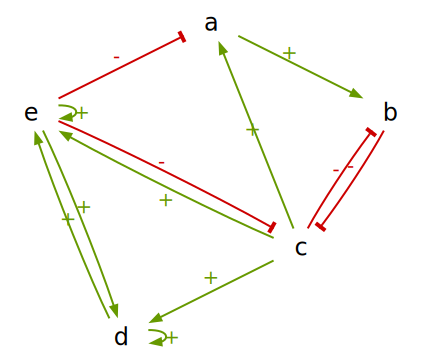

In [11]:
display_IG(ig, f"synthetic_{MODEL_ID}.pdf")

In [12]:
dyn = f.dynamics("asynchronous")
dyn

# computing graph layout...


In [13]:
steady_states = {f"steady{i}": x for i, x in enumerate(f.fixedpoints())}
steady_states

{'steady0': {'a': 0, 'b': 0, 'c': 0, 'd': 1, 'e': 1},
 'steady1': {'a': 1, 'b': 0, 'c': 1, 'd': 0, 'e': 0}}

In [14]:
nodes = tuple(f)
def make_cfg(n):
    return dict(zip(nodes, map(int, n)))
transitions = [(make_cfg(x), make_cfg(y)) for x, y in dyn.edges()]
len(transitions)


64

In [15]:
f.save(f"synthetic_{MODEL_ID}.bnet")

In [16]:
truth_ig = extract_edges(f.influence_graph())
truth_ig

[('a', 'b', 1),
 ('b', 'c', -1),
 ('c', 'a', 1),
 ('c', 'b', -1),
 ('c', 'd', 1),
 ('c', 'e', 1),
 ('d', 'd', 1),
 ('d', 'e', 1),
 ('e', 'a', -1),
 ('e', 'c', -1),
 ('e', 'd', 1),
 ('e', 'e', 1)]

### Transitions

In [17]:
tests = list(range(0, len(transitions)-1, 4)) + [len(transitions)]

results = {}
random.shuffle(transitions)
for nb_trans in tqdm(tests):

    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady_states:
        bo.fixed(~bo.obs(s))
    # transitions
    with bo.scope_reachability(max_changes=1, monotone=True):
        for x, y in transitions[:nb_trans]:
            ~bo.obs(x) >= ~bo.obs(y)

    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results[nb_trans] = r

100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:28<00:00,  1.65s/it]


In [18]:
make_stats(results)

,min models,size,overlap (/12),spurious trans,missing trans
0,256,4,0-4,4-48,12-52
4,64,4,1-4,8-44,12-40
8,256,6-8,1-6,8-47,8-35
12,64,6-8,2-7,8-39,4-19
16,64,7-10,3-7,14-39,4-13
20,32,8-10,4-8,16-37,0-11
24,32,8-11,4-8,16-35,0-9
28,16,8-13,5-8,16-35,0-7
32,8,8-14,5-8,16-37,0-7
36,8,8-14,5-8,16-42,0-6


### Steady states

In [19]:
steady = list(steady_states.keys())
random.shuffle(steady)

results_fp = {}
for nb_steady in tqdm(range(0,len(steady)+1)):
    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady[:nb_steady]:
        bo.fixed(~bo.obs(s))
        
    # transitions (all)
    with bo.scope_reachability(max_changes=1, monotone=True):
        for x, y in transitions:
            ~bo.obs(x) >= ~bo.obs(y)
    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results_fp[nb_steady] = r

100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.70s/it]


In [20]:
make_stats(results_fp)

,min models,size,overlap (/12),spurious trans,missing trans
0,16,4-7,0-7,16-80,0
1,12,7,4-7,16-40,0
2,1,8,8,16,0


### Influence graph

We enforce all the fixed points, no transition, and vary the number of influences.

In [21]:
random.shuffle(truth_ig)
results_ig = {}
for size in tqdm(range(0,len(truth_ig)+1)):
    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady[:nb_steady]:
        bo.fixed(~bo.obs(s))

    # enforce interactions
    for a, b, s in truth_ig[:size]:
        bo.custom(f":- not clause(\"{b}\",_,\"{a}\",{s}).")
    
    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results_ig[size] = r

100%|█████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.11it/s]


In [22]:
make_stats(results_ig)

,min models,size,overlap (/12),spurious trans,missing trans
0,256,4,0-4,4-48,12-52
1,64,4,1-4,8-44,12-40
2,16,4,2-4,12-40,12-28
3,4,4,3-4,16-32,12-16
4,1,4,4,28,12
5,4,6,5-6,24-30,12-14
6,16,8,6-8,20-30,8-18
7,4,8,7-8,20-24,16-24
8,4,9,8-9,16-20,4-16
9,4,10,9-10,12-24,4-20


## Synthetic model 2

In [23]:
MODEL_ID = 1

In [24]:
f = bns[MODEL_ID]
ig = f.influence_graph()

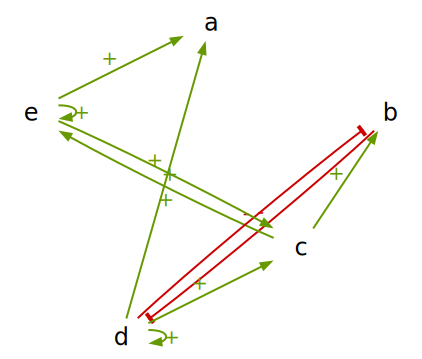

In [25]:
display_IG(ig, f"synthetic_{MODEL_ID}.pdf")

In [26]:
dyn = f.dynamics("asynchronous")
dyn

# computing graph layout...


In [27]:
steady_states = {f"steady{i}": x for i, x in enumerate(f.fixedpoints())}
steady_states

{'steady0': {'a': 1, 'b': 0, 'c': 1, 'd': 1, 'e': 1},
 'steady1': {'a': 0, 'b': 0, 'c': 0, 'd': 1, 'e': 0}}

In [28]:
nodes = tuple(f)
def make_cfg(n):
    return dict(zip(nodes, map(int, n)))
transitions = [(make_cfg(x), make_cfg(y)) for x, y in dyn.edges()]
len(transitions)


64

In [29]:
f.save(f"synthetic_{MODEL_ID}.bnet")

In [30]:
truth_ig = extract_edges(f.influence_graph())
truth_ig

[('b', 'd', -1),
 ('c', 'b', 1),
 ('c', 'e', 1),
 ('d', 'a', 1),
 ('d', 'b', -1),
 ('d', 'c', 1),
 ('d', 'd', 1),
 ('e', 'a', 1),
 ('e', 'c', 1),
 ('e', 'e', 1)]

### Transitions

In [31]:
tests = list(range(0, len(transitions)-1, 4)) + [len(transitions)]

results = {}
random.shuffle(transitions)
for nb_trans in tqdm(tests):

    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady_states:
        bo.fixed(~bo.obs(s))
    # transitions
    with bo.scope_reachability(max_changes=1, monotone=True):
        for x, y in transitions[:nb_trans]:
            ~bo.obs(x) >= ~bo.obs(y)

    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results[nb_trans] = r

100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:33<00:00,  1.97s/it]


In [32]:
make_stats(results)

,min models,size,overlap (/10),spurious trans,missing trans
0,27,3,0-3,12-40,12-44
4,6,4,2-4,24-36,12-28
8,6,5,3-5,24-32,8-20
12,6,5-7,3-5,24-30,8-16
16,6,6-8,4-6,20-28,4-14
20,6,6-8,4-6,20-28,4-14
24,6,6-9,4-6,20-31,4-13
28,18,7-11,4-7,16-33,0-13
32,12,7-11,4-7,16-37,0-11
36,4,7-9,5-7,16-29,0-3


### Steady states

In [33]:
steady = list(steady_states.keys())
random.shuffle(steady)

results_fp = {}
for nb_steady in tqdm(range(0,len(steady)+1)):
    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady[:nb_steady]:
        bo.fixed(~bo.obs(s))
        
    # transitions (all)
    with bo.scope_reachability(max_changes=1, monotone=True):
        for x, y in transitions:
            ~bo.obs(x) >= ~bo.obs(y)
    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results_fp[nb_steady] = r

100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.85s/it]


In [34]:
make_stats(results_fp)

,min models,size,overlap (/10),spurious trans,missing trans
0,8,3-6,0-6,16-64,0
1,2,6,5-6,16-24,0
2,2,7,6-7,16-24,0


### Influence graph

We enforce all the fixed points, no transition, and vary the number of influences.

In [35]:
random.shuffle(truth_ig)
results_ig = {}
for size in tqdm(range(0,len(truth_ig)+1)):
    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady[:nb_steady]:
        bo.fixed(~bo.obs(s))

    # enforce interactions
    for a, b, s in truth_ig[:size]:
        bo.custom(f":- not clause(\"{b}\",_,\"{a}\",{s}).")
    
    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results_ig[size] = r

100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.26it/s]


In [36]:
make_stats(results_ig)

,min models,size,overlap (/10),spurious trans,missing trans
0,27,3,0-3,12-40,12-44
1,27,4,1-4,12-36,8-36
2,27,5,2-5,12-36,8-36
3,9,5,3-5,12-24,16-36
4,9,6,4-6,8-20,12-32
5,3,6,5-6,12-16,12-20
6,1,6,6,12,12
7,1,7,7,12,12
8,1,8,8,20,12
9,1,9,9,16,8


## Synthetic model 3

In [37]:
MODEL_ID = 2

In [38]:
f = bns[MODEL_ID]
ig = f.influence_graph()

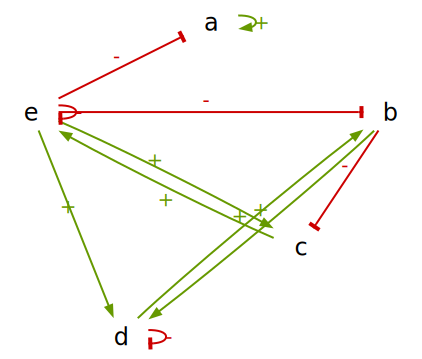

In [39]:
display_IG(ig, f"synthetic_{MODEL_ID}.pdf")

In [40]:
dyn = f.dynamics("asynchronous")
dyn

# computing graph layout...


In [41]:
steady_states = {f"steady{i}": x for i, x in enumerate(f.fixedpoints())}
steady_states

{'steady0': {'a': 1, 'b': 0, 'c': 1, 'd': 1, 'e': 1},
 'steady1': {'a': 0, 'b': 0, 'c': 1, 'd': 1, 'e': 1}}

In [42]:
nodes = tuple(f)
def make_cfg(n):
    return dict(zip(nodes, map(int, n)))
transitions = [(make_cfg(x), make_cfg(y)) for x, y in dyn.edges()]
len(transitions)


84

In [43]:
f.save(f"synthetic_{MODEL_ID}.bnet")

In [44]:
truth_ig = extract_edges(f.influence_graph())
truth_ig

[('a', 'a', 1),
 ('b', 'c', -1),
 ('b', 'd', 1),
 ('c', 'e', 1),
 ('d', 'b', 1),
 ('d', 'd', -1),
 ('e', 'a', -1),
 ('e', 'b', -1),
 ('e', 'c', 1),
 ('e', 'd', 1),
 ('e', 'e', -1)]

### Transitions

In [45]:
tests = list(range(0, len(transitions)-1, 4)) + [len(transitions)]

results = {}
random.shuffle(transitions)
for nb_trans in tqdm(tests):

    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady_states:
        bo.fixed(~bo.obs(s))
    # transitions
    with bo.scope_reachability(max_changes=1, monotone=True):
        for x, y in transitions[:nb_trans]:
            ~bo.obs(x) >= ~bo.obs(y)

    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results[nb_trans] = r

100%|█████████████████████████████████████████████████████████████████████| 22/22 [01:22<00:00,  3.75s/it]


In [46]:
make_stats(results)

,min models,size,overlap (/11),spurious trans,missing trans
0,1,1,1,16,36
4,2,4,3-4,8-12,20-24
8,8,6,3-6,10-18,16-27
12,4,6,4-6,10-14,16-23
16,32,9-10,4-9,4-18,4-25
20,16,9-10,5-9,4-14,4-21
24,48,10-12,5-10,0-20,0-23
28,36,10-11,5-10,3-20,0-23
32,18,10-11,6-10,3-20,0-13
36,18,10-12,7-10,1-20,0-11


### Steady states

In [47]:
steady = list(steady_states.keys())
random.shuffle(steady)

results_fp = {}
for nb_steady in tqdm(range(0,len(steady)+1)):
    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady[:nb_steady]:
        bo.fixed(~bo.obs(s))
        
    # transitions (all)
    with bo.scope_reachability(max_changes=1, monotone=True):
        for x, y in transitions:
            ~bo.obs(x) >= ~bo.obs(y)
    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results_fp[nb_steady] = r

100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.31s/it]


In [48]:
stats = make_stats(results_fp)
print(stats.to_markdown())

|    |   min models | size   | overlap (/11)   | spurious trans   |   missing trans |
|---:|-------------:|:-------|:----------------|:-----------------|----------------:|
|  0 |            4 | 4-6    | 2-6             | 28-60            |               0 |
|  1 |            2 | 9      | 8-9             | 12-20            |               0 |
|  2 |            2 | 10     | 9-10            | 4-12             |               0 |


### Influence graph

We enforce all the fixed points, no transition, and vary the number of influences.

In [49]:
random.shuffle(truth_ig)
results_ig = {}
for size in tqdm(range(0,len(truth_ig)+1)):
    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady[:nb_steady]:
        bo.fixed(~bo.obs(s))

    # enforce interactions
    for a, b, s in truth_ig[:size]:
        bo.custom(f":- not clause(\"{b}\",_,\"{a}\",{s}).")
    
    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results_ig[size] = r

100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.98it/s]


In [50]:
make_stats(results_ig)

,min models,size,overlap (/11),spurious trans,missing trans
0,1,1,1,16,36
1,1,2,2,16,28
2,1,3,3,8,20
3,1,4,4,12,24
4,3,6,5-6,12-16,16-20
5,3,7,6-7,16-20,20-24
6,3,7,6-7,8-12,12-16
7,3,8,7-8,8-12,12-16
8,3,9,8-9,16-20,12-16
9,3,10,9-10,8-12,8-12


## Synthetic model 4

In [51]:
MODEL_ID = 3

In [52]:
f = bns[MODEL_ID]
ig = f.influence_graph()

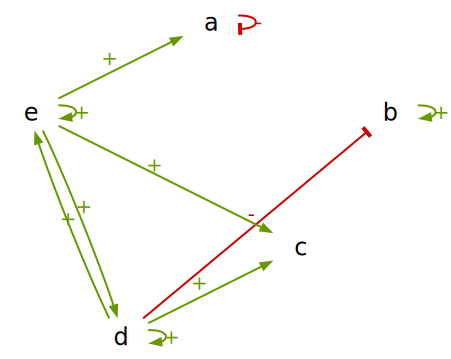

In [53]:
display_IG(ig, f"synthetic_{MODEL_ID}.pdf")

In [54]:
dyn = f.dynamics("asynchronous")
dyn

# computing graph layout...


In [55]:
steady_states = {f"steady{i}": x for i, x in enumerate(f.fixedpoints())}
steady_states

{'steady0': {'a': 1, 'b': 0, 'c': 1, 'd': 1, 'e': 1},
 'steady1': {'a': 1, 'b': 0, 'c': 0, 'd': 0, 'e': 1},
 'steady2': {'a': 1, 'b': 1, 'c': 0, 'd': 0, 'e': 1}}

In [56]:
nodes = tuple(f)
def make_cfg(n):
    return dict(zip(nodes, map(int, n)))
transitions = [(make_cfg(x), make_cfg(y)) for x, y in dyn.edges()]
len(transitions)


64

In [57]:
f.save(f"synthetic_{MODEL_ID}.bnet")

In [58]:
truth_ig = extract_edges(f.influence_graph())
truth_ig

[('a', 'a', -1),
 ('b', 'b', 1),
 ('d', 'b', -1),
 ('d', 'c', 1),
 ('d', 'd', 1),
 ('d', 'e', 1),
 ('e', 'a', 1),
 ('e', 'c', 1),
 ('e', 'd', 1),
 ('e', 'e', 1)]

### Transitions

In [59]:
tests = list(range(0, len(transitions)-1, 4)) + [len(transitions)]

results = {}
random.shuffle(transitions)
for nb_trans in tqdm(tests):

    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady_states:
        bo.fixed(~bo.obs(s))
    # transitions
    with bo.scope_reachability(max_changes=1, monotone=True):
        for x, y in transitions[:nb_trans]:
            ~bo.obs(x) >= ~bo.obs(y)

    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results[nb_trans] = r

100%|█████████████████████████████████████████████████████████████████████| 17/17 [00:27<00:00,  1.63s/it]


In [60]:
make_stats(results)

,min models,size,overlap (/10),spurious trans,missing trans
0,4,3,1-3,8-24,24-40
4,6,4,2-4,12-22,20-24
8,4,4,2-4,12-22,20-22
12,4,5,3-5,8-18,16-18
16,12,7-8,4-7,8-20,8-16
20,12,8,5-8,8-22,0-6
24,8,8,6-8,8-20,0-4
28,8,8,6-8,8-20,0-4
32,8,8,6-8,8-20,0-4
36,4,8,6-8,8-20,0-4


### Steady states

In [61]:
steady = list(steady_states.keys())
random.shuffle(steady)

results_fp = {}
for nb_steady in tqdm(range(0,len(steady)+1)):
    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady[:nb_steady]:
        bo.fixed(~bo.obs(s))
        
    # transitions (all)
    with bo.scope_reachability(max_changes=1, monotone=True):
        for x, y in transitions:
            ~bo.obs(x) >= ~bo.obs(y)
    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results_fp[nb_steady] = r

100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.85s/it]


In [62]:
make_stats(results_fp)

,min models,size,overlap (/10),spurious trans,missing trans
0,2,2-3,1-3,32-48,0
1,1,5,5,24,0
2,3,7,6-7,16-24,0
3,2,8,7-8,8-16,0


### Influence graph

We enforce all the fixed points, no transition, and vary the number of influences.

In [63]:
random.shuffle(truth_ig)
results_ig = {}
for size in tqdm(range(0,len(truth_ig)+1)):
    bo = bonesis.BoNesis(bonesis.InfluenceGraph.complete(nodes), data=steady_states)
    # enforce steady states
    for s in steady[:nb_steady]:
        bo.fixed(~bo.obs(s))

    # enforce interactions
    for a, b, s in truth_ig[:size]:
        bo.custom(f":- not clause(\"{b}\",_,\"{a}\",{s}).")
    
    r = []
    for c,(ig,bn) in enumerate(bonesis.InfluenceGraphView(bo, solutions="subset-minimal", extra="boolean-network")):
        r.append((extract_edges(ig),bn))
    results_ig[size] = r

100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.09it/s]


In [64]:
make_stats(results_ig)

,min models,size,overlap (/10),spurious trans,missing trans
0,4,3,1-3,8-24,24-40
1,4,4,2-4,8-24,24-40
2,4,5,3-5,0-16,32-48
3,4,6,4-6,0-16,24-40
4,4,6,4-6,0-16,24-40
5,2,6,5-6,0-4,28-40
6,1,6,6,4,28
7,1,7,7,0,24
8,1,8,8,0,16
9,1,9,9,0,8
